In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [5]:
input_dir = '/Users/xiaohanzhao/Projects/Dinov3_ST/napari/data/Visium_HD_Human_Kidney_FFPE/maskann_size-512'
coord = 'r0_c512'
he_mask = np.load(f'{input_dir}/sam2_HE_masks/{coord}_he_mask.npy')
he_inst = pd.read_csv(f'{input_dir}/sam2_HE_masks/{coord}_he_mask_info.csv')
st_mask = np.load(f'{input_dir}/sam2_ST_masks/{coord}_rgb_mask.npy')
st_inst = pd.read_csv(f'{input_dir}/sam2_ST_masks/{coord}_rgb_mask_info.csv')

In [9]:
print(he_mask.shape, st_mask.shape)

(3758, 3723) (512, 512)


In [18]:
len(np.unique(he_mask))

373

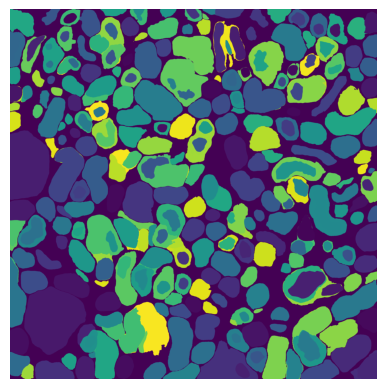

In [7]:
plt.imshow(he_mask)
plt.axis('off')
plt.show()  

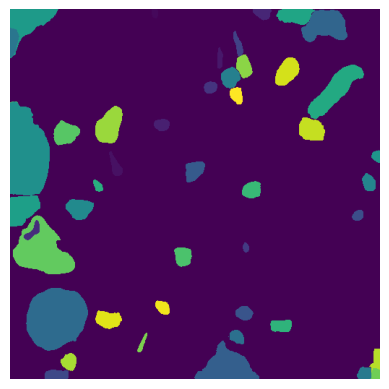

In [8]:
plt.imshow(st_mask)
plt.axis('off')
plt.show() 

[OK] coord=r0_c512
  HE patch: (3758, 3723) -> HE_512 instances: 366
  ST_512 instances: 46
  fused instances: 410
  report: /Users/xiaohanzhao/Projects/Dinov3_ST/napari/data/Visium_HD_Human_Kidney_FFPE/maskann_size-512/sam2_fused_masks/r0_c512_merge_report.csv


In [25]:
import numpy as np
import pandas as pd
from PIL import Image

input_dir = '/Users/xiaohanzhao/Projects/Dinov3_ST/napari/data/Visium_HD_Human_Kidney_FFPE/maskann_size-512'
coord = 'r0_c512'

he_mask = np.load(f'{input_dir}/sam2_HE_masks/{coord}_he_mask.npy')
he_info = pd.read_csv(f'{input_dir}/sam2_HE_masks/{coord}_he_mask_info.csv')

st_mask = np.load(f'{input_dir}/sam2_ST_masks/{coord}_rgb_mask.npy')
st_info = pd.read_csv(f'{input_dir}/sam2_ST_masks/{coord}_rgb_mask_info.csv')

# 1) resize HE mask -> (512,512), nearest
he_mask_512 = np.array(
    Image.fromarray(he_mask.astype(np.int32), mode="I").resize((512, 512), resample=Image.NEAREST),
    dtype=np.int32,
)

# 2) shift HE labels to avoid collision with ST ids
st_mask_i = st_mask.astype(np.int32)
offset = int(st_mask_i.max())

he_shift = he_mask_512.copy()
he_shift[he_shift > 0] += offset

# 3) merge: ST overwrites HE where ST>0
merged = he_shift
merged[st_mask_i > 0] = st_mask_i[st_mask_i > 0]

# 4) merge info: shift HE ids + offset, keep only ids that exist in merged
he_info2 = he_info.copy()
he_info2["id"] = he_info2["id"].astype(int) + offset
he_info2["source"] = "HE"

st_info2 = st_info.copy()
st_info2["id"] = st_info2["id"].astype(int)
st_info2["source"] = "ST"

merged_info = pd.concat([st_info2, he_info2], ignore_index=True)

valid_ids = set(np.unique(merged))
valid_ids.discard(0)
merged_info = merged_info[merged_info["id"].isin(valid_ids)].reset_index(drop=True)

# 5) save
os.makedirs(f"{input_dir}/sam2_merged_masks", exist_ok=True)
out_mask = f"{input_dir}/sam2_merged_masks/{coord}_merged_mask.npy"
out_info = f"{input_dir}/sam2_merged_masks/{coord}_merged_mask_info.csv"

np.save(out_mask, merged.astype(np.int32))
merged_info.to_csv(out_info, index=False)

print(f'HE instances: {len(np.unique(he_mask))}')
print(f'ST instances: {len(np.unique(st_mask))}')
print(f'merged instances: {len(np.unique(merged))}')
print("[ok] wrote:", out_mask)
print("[ok] wrote:", out_info)

HE instances: 373
ST instances: 47
merged instances: 398
[ok] wrote: /Users/xiaohanzhao/Projects/Dinov3_ST/napari/data/Visium_HD_Human_Kidney_FFPE/maskann_size-512/sam2_merged_masks/r0_c512_merged_mask.npy
[ok] wrote: /Users/xiaohanzhao/Projects/Dinov3_ST/napari/data/Visium_HD_Human_Kidney_FFPE/maskann_size-512/sam2_merged_masks/r0_c512_merged_mask_info.csv
